# Hybrid scalability test - Combining MPI and OpenMP tests

extract the data

In [12]:
import csv

# Define the name of the log file and output data CSV file
log_file = 'hybrid_scal.log'
csv_file = 'hybrid_scaling.csv'

# Storing data
data = []
current_data = {}
omp_thread_counts = [1, 2, 4, 8, 12]
omp_index = 0

# Initialize variable to hold the number of MPI processes
mpi_processes = None

# Read log file and extract data
with open(log_file, 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('Command being timed:'):
            if current_data:
                data.append(current_data)
                current_data = {}

            # Extract MPI processes from the command
            command = line.split('"')[1]
            parts = command.split()
            mpi_processes = parts[2]  # Get number of MPI processes

            current_data['MPI Processes'] = mpi_processes
            current_data['OpenMP Threads'] = omp_thread_counts[omp_index]  # Cycle through OpenMP thread counts

            # Move to the next OpenMP thread count
            omp_index = (omp_index + 1) % len(omp_thread_counts)

        elif ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip().split(' ')[0]  # To remove units and extra info
            current_data[key] = value

    # Add the last block of data if any
    if current_data:
        data.append(current_data)

# Write data to CSV file
fieldnames = ['MPI Processes', 'OpenMP Threads'] + list(data[0].keys())[2:]  # Get the keys of the first element of the list

with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for entry in data:
        writer.writerow(entry)

print('Data extracted and saved to', csv_file)


Data extracted and saved to hybrid_scaling.csv


# Analysis

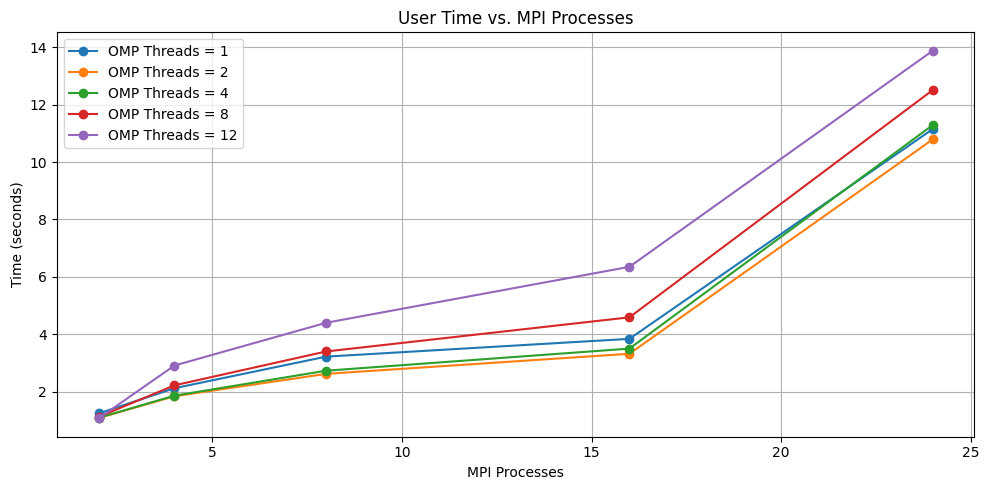

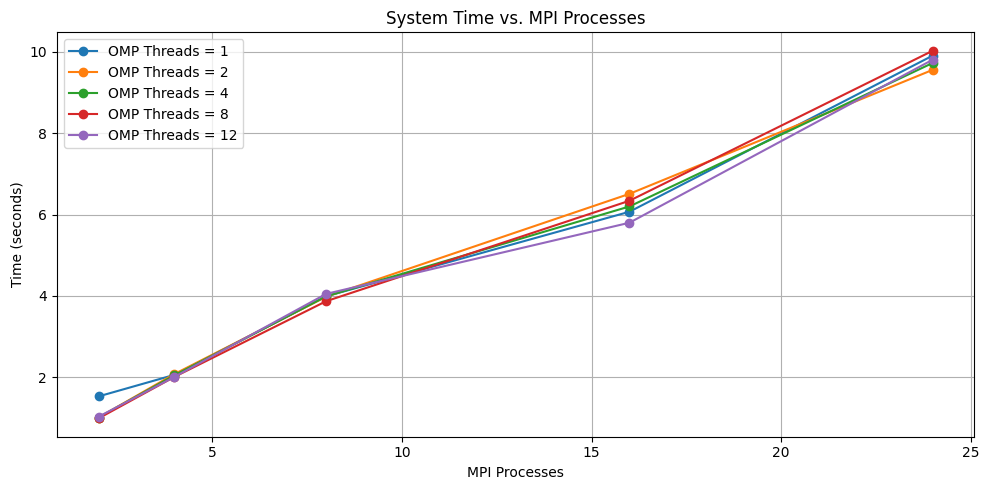

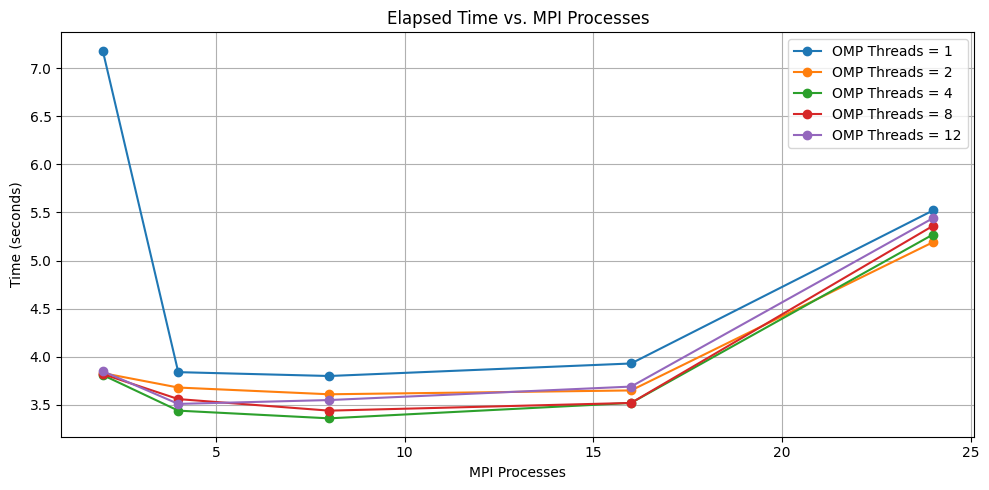

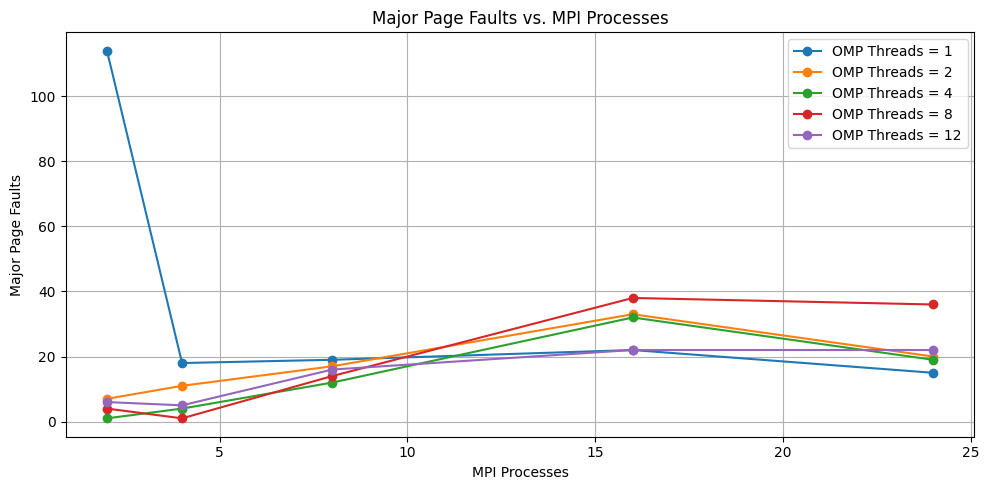

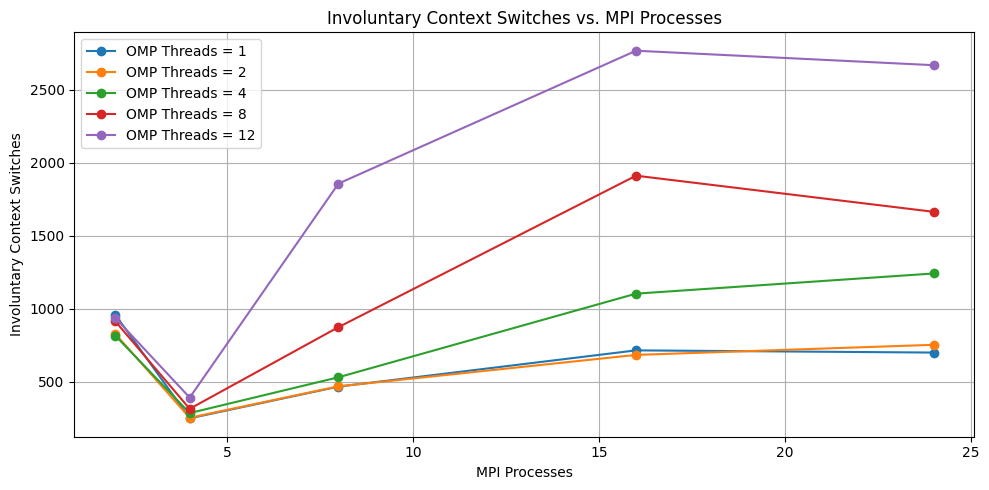

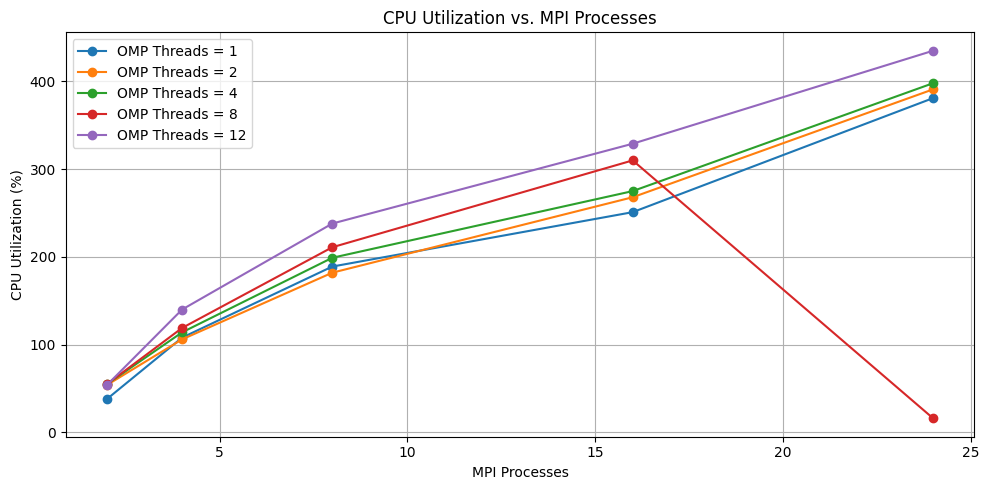

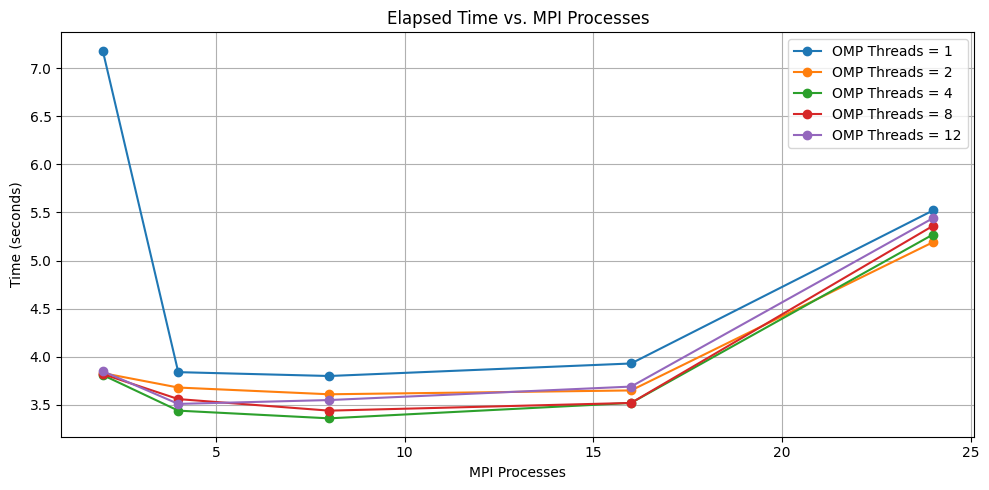

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
csv_file = 'hybrid_scaling.csv'
data = pd.read_csv(csv_file)

# Convert relevant columns to numeric types
data['MPI Processes'] = data['MPI Processes'].astype(int)
data['OpenMP Threads'] = data['OpenMP Threads'].astype(int)
data['Percent of CPU this job got'] = data['Percent of CPU this job got'].str.rstrip('%').astype('float')
data['Elapsed (wall clock) time (ss)'] = data['Elapsed (wall clock) time (ss)'].astype(float)
data['User time (seconds)'] = data['User time (seconds)'].astype(float)
data['System time (seconds)'] = data['System time (seconds)'].astype(float)
data['Major (requiring I/O) page faults'] = data['Major (requiring I/O) page faults'].astype(int)
data['Involuntary context switches'] = data['Involuntary context switches'].astype(int)

# Create a function to generate plots
def generate_plots(data, y_label, y_column, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    for omp in sorted(data['OpenMP Threads'].unique()):
        subset = data[data['OpenMP Threads'] == omp]
        ax.plot(subset['MPI Processes'], subset[y_column], marker='o', label=f'OMP Threads = {omp}')
    ax.set_title(title)
    ax.set_xlabel('MPI Processes')
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Efficiency Plots
generate_plots(data, 'Time (seconds)', 'User time (seconds)', 'User Time vs. MPI Processes')
generate_plots(data, 'Time (seconds)', 'System time (seconds)', 'System Time vs. MPI Processes')
generate_plots(data, 'Time (seconds)', 'Elapsed (wall clock) time (ss)', 'Elapsed Time vs. MPI Processes')

# Bottlenecks Plots
generate_plots(data, 'Major Page Faults', 'Major (requiring I/O) page faults', 'Major Page Faults vs. MPI Processes')
generate_plots(data, 'Involuntary Context Switches', 'Involuntary context switches', 'Involuntary Context Switches vs. MPI Processes')

# Parallelization Impact Plots
generate_plots(data, 'CPU Utilization (%)', 'Percent of CPU this job got', 'CPU Utilization vs. MPI Processes')
generate_plots(data, 'Time (seconds)', 'Elapsed (wall clock) time (ss)', 'Elapsed Time vs. MPI Processes')


## Analysis 

### Efficiency

- **Scalability**: The decrease in elapsed time from 2 to 4 MPI processes shows initial scalability. However, beyond 4 MPI processes, the performance gains are less clear, and in some cases, the elapsed time increases. The system time increases linearly, indicating that the computational overhead scales proportionally with more MPI processes.

- **Threading Efficiency**: Higher OpenMP thread counts (8 and 12) show significantly higher user times, which might indicate inefficiencies or overhead in managing a large number of threads. For lower MPI process counts, using more OpenMP threads seems to improve elapsed time, but this benefit diminishes as the number of MPI processes increases.

- **Optimal Configuration**: For the given setup, using around 4 MPI processes with moderate OpenMP threads (4-8) seems to provide a good balance between user time, system time, and elapsed time. Using too many OpenMP threads (12) significantly increases user time, which suggests diminishing returns or potential bottlenecks in threading.


### Bottlenecks

- **Context Switch Overhead**: The increase in involuntary context switches with higher OpenMP threads suggests significant overhead in managing threads, particularly for configurations with many MPI processes. This could be due to thread contention, synchronization issues, or inefficient scheduling.

- **Memory Access Issues**: The initial high number of major page faults for 1 OpenMP thread with 2 MPI processes may indicate memory access patterns that cause significant paging. However, this issue diminishes with more processes and threads. For higher OpenMP thread counts, the increased page faults suggest potential memory contention or inefficient use of shared memory resources.

- **Optimal Configuration**: To minimize context switches and page faults, a balanced configuration with moderate MPI processes and OpenMP threads (e.g., 4-8 threads) appears optimal. Avoid configurations with excessively high thread counts (e.g., 12 threads) as they introduce significant overhead and inefficiencies.





### Parallelization Impact

- **Scalability and Efficiency**: The initial decrease in elapsed time from 2 to 4 MPI processes shows good scalability and parallel efficiency. Beyond 4 MPI processes, the benefits of additional processes diminish, and the system might be hitting resource contention or communication overheads, especially evident at 24 MPI processes.

- **Threading Efficiency**: Higher OpenMP thread counts (8 and 12) improve CPU utilization, indicating better use of multicore resources. The anomaly observed with 8 OpenMP threads at 24 MPI processes suggests there might be specific issues with this configuration, potentially due to over-subscription or inefficiencies in thread management.

- **Optimal Configuration**: The best performance in terms of minimizing elapsed time and maximizing CPU utilization seems to be around 4-8 MPI processes with 4-8 OpenMP threads. Extremely high thread counts (12) can lead to higher CPU utilization but also increased overheads, affecting user time and system time negatively.

## Conclusion

This investigation into the scalability of the Mandelbrot set computation using a hybrid MPI and OpenMP setup reveals several key insights into efficiency, bottlenecks, and parallelization impact.

### Efficiency

The efficiency analysis shows that user time, system time, and elapsed time are crucial metrics. User time tends to increase with the number of MPI processes, with a significant rise when using higher OpenMP thread counts, particularly at 12 threads. System time increases linearly with MPI processes, indicating a proportional computational overhead. Elapsed time decreases significantly when moving from 2 to 4 MPI processes, demonstrating good initial scalability. However, beyond 4 MPI processes, the benefits diminish, and elapsed time either stabilizes or slightly increases. The optimal configuration for efficiency is around 4-8 MPI processes with 4-8 OpenMP threads, avoiding configurations with 12 threads due to increased overhead.

### Bottlenecks

The bottleneck analysis focuses on major page faults and involuntary context switches. Involuntary context switches increase with the number of MPI processes, especially at higher OpenMP thread counts, indicating thread management overhead. Major page faults are initially high with 1 thread and 2 MPI processes but stabilize with higher process counts. Configurations with higher thread counts tend to have more page faults, suggesting memory contention or inefficiencies. Minimizing bottlenecks involves using moderate MPI processes (4-8) and OpenMP threads (4-8), avoiding the overhead introduced by high thread counts.

### Parallelization Impact

The parallelization impact is assessed through CPU utilization and elapsed time. CPU utilization increases with MPI processes and higher OpenMP thread counts, indicating effective use of multicore resources. An anomaly with 8 OpenMP threads at 24 MPI processes shows a significant drop in CPU utilization, suggesting resource contention or inefficiencies at higher concurrency levels. Elapsed time decreases significantly from 2 to 4 MPI processes, demonstrating good scalability, but stabilizes or increases slightly beyond this point. Lower thread counts (1-2) result in higher elapsed times compared to higher counts (4-12).

### Optimal Configuration and Recommendations

The best performance for the Mandelbrot set computation is achieved with 4-8 MPI processes and 4-8 OpenMP threads. Extremely high thread counts (12) lead to higher CPU utilization but also increased overheads, negatively impacting efficiency. To further optimize performance:

- Investigate and optimize thread management to reduce user time and context switches at high thread counts.
- Optimize memory access patterns to reduce major page faults and improve overall efficiency.
- Conduct additional tests with configurations around 4-8 MPI processes and 4-8 OpenMP threads to refine the optimal setup.
- Use profiling tools to identify and optimize specific functions or operations causing inefficiencies.